### Build and train a simple Recurrent Neural Network
We are going to use writings of shakespear as our data.

Steps:
- Download the data
- Preprocessing the data
- Create character tokenizer
- Tokenize data
- Split data (train / test)
- Create a batches of data to be fed to the model
- Define parameters for the model
- Initialize the model
- Overfit a single batch
- Train the model
- Generate text

In [27]:
# Imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [2]:
# Download the data 
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt        

In [3]:
with open('input.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [4]:
print(f'Total number of characters: {len(text)}')

Total number of characters: 1115394


In [5]:
# All unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'Number of unique characters: {vocab_size}')
''.join(chars)

Number of unique characters: 65


"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [6]:
# Character level tokenizer
stoi = {char: idx for idx, char in enumerate(chars)}
itos = {idx: char for char, idx in stoi.items()}

encode = lambda s: [stoi[char] for char in s]
decode = lambda i: ''.join([itos[idx] for idx in i])

print(encode('hello there!'))
print(decode(encode('hello there!')))

[46, 43, 50, 50, 53, 1, 58, 46, 43, 56, 43, 2]
hello there!


In [7]:
# Tokenize all text
data = torch.tensor(encode(text), dtype=torch.long)

In [8]:
# Looking at some raw text 
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [9]:
# Looking at tokenized text
data[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [10]:
def train_test_split(data, test_pct=.1):
    data_size = len(data)
    num_test_samples = int(data_size * test_pct)
    test_data = data[-num_test_samples:]
    train_data = data[:data_size - num_test_samples]
    return train_data, test_data

In [11]:
train_data, test_data = train_test_split(data)
print(f'size of training set: {len(train_data)}')
print(f'size of test set: {len(test_data)}')

assert len(train_data) + len(test_data) == len(data), "Lost data during train test split"

size of training set: 1003855
size of test set: 111539


In [13]:
# Function to get a batch
def get_random_batch(data, batch_size=4, block_size=8):
    # Get  batch_size of random indices which will be the start of sequence
    # Ensure that indices start before the length of data - block_size to prevent out of bounds error
    idx = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in idx])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in idx])
    return x, y

# Grab a sample batch
x, y = get_random_batch(train_data,)
print('features:')
print(x)
print('labels')
print(y)
print(x.shape, y.shape)

features:
tensor([[57, 47, 52, 45,  1, 41, 53, 61],
        [ 1, 57, 59, 41, 46,  1, 39,  1],
        [37,  1, 34, 21,  0,  0, 23, 21],
        [43,  1, 40, 39, 40, 43,  6,  0]])
labels
tensor([[47, 52, 45,  1, 41, 53, 61, 39],
        [57, 59, 41, 46,  1, 39,  1, 41],
        [ 1, 34, 21,  0,  0, 23, 21, 26],
        [ 1, 40, 39, 40, 43,  6,  0, 21]])
torch.Size([4, 8]) torch.Size([4, 8])


In [14]:
def get_batch_sequentially(data, batch_size=4, block_size=8):
    size_of_data = len(data) - 1 # subtracting one for the label 
    for idx in range(0, size_of_data, block_size*batch_size):
        x = torch.stack([data[idx + i: idx + block_size + i] for i in range(batch_size)])
        y = torch.stack([data[idx + i + 1: idx + block_size + i + 1] for i in range(batch_size)])
        yield x, y

In [15]:
# rnn = RNN(vocab_size, emb_dim, n_hidden)
@torch.no_grad()
def evaluate(model, batch_size=4, block_size=8):
    train_loader = get_batch_sequentially(train_data, batch_size=batch_size, block_size=block_size)
    test_loader = get_batch_sequentially(test_data,  batch_size=batch_size, block_size=block_size)

    loss_i = []
    for loader in (train_loader, test_loader):
            for x, y in loader:
                loss, _ = rnn(x, y)
                loss_i.append(loss)
            if loader == train_loader:    
                print(f'average training loss: {sum(loss_i)/len(loss_i):.4f}', end=' | ')
            else:
                print(f'average test loss: {sum(loss_i)/len(loss_i):.4f}')
# evaluate(rnn)

In [16]:
@torch.no_grad()
def generate(prompt, model, block_size=8, max_output_size=50):
    # Handle prompts shorter than block_size
    if len(prompt) < block_size:
        count_missing = block_size - len(prompt)
        prompt = (count_missing * ' ') + prompt
    prompt_tok = encode(prompt)
    print(prompt, end='')
    # trim text longer than block size
    prompt_trimmed = prompt_tok[-block_size:]
    for i in range(max_output_size):
        prompt_trimmed_tnsr = torch.tensor(prompt_trimmed).unsqueeze(0)
        loss, logits = rnn(prompt_trimmed_tnsr)
        # import pdb; pdb.set_trace()
        probs = F.softmax(logits[:, block_size-1], dim=1)
        idx = torch.multinomial(probs, 1, replacement=True)
        print(decode([idx.item()]), end='')
        prompt_trimmed.pop()
        prompt_trimmed.append(idx.item())

In [17]:
class RNNCell(nn.Module):
    def __init__(self, emb_dim, n_hidden):
        super().__init__()
        self.linear = nn.Linear(emb_dim+n_hidden, n_hidden)

    def forward(self, x, hidden):
        # print(f'{x.shape=}, {hidden.shape=}, {self.linear.weight.shape=}')
        h = torch.cat((x, hidden), dim=1) # shape b x emb_dim + n_hidden
        # print(f'{h.shape=}')
        return self.linear(h) # shape b x n_hidden

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, n_hidden):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(self.vocab_size, self.emb_dim)
        self.rnn = RNNCell(self.emb_dim, self.n_hidden)
        self.tanh = nn.Tanh()
        self.hidden_state = torch.zeros((1, self.n_hidden), requires_grad=True)
        self.linear = nn.Linear(self.n_hidden, self.vocab_size)

    def forward(self, x, targets=None):
        x = self.emb(x)
        b, t, e = x.shape # shape: batch x block_size x emb_dim

        h = self.hidden_state.expand((b, -1)) # shape: batch x n_hidden
        list_hidden_states = []
        # Pass tokens through the model
        for i in range(t):
            # h = h + self.tanh(self.rnn(x[:, i, :])) # dim after slicing: b x emb --> output shape: b x n_hidden
            x_t = x[:, i, :]
            h = self.tanh(self.rnn(x_t, h)) # h's shape: b x n_hidden
            list_hidden_states.append(h)

        # hidden acts is a list of (b x n_hidden) (t items in the list)
        # hidden shape = 4 x 100 | list_hiddden_states length = 8
        # pull all cols (each row starting from 0)
        # 4 x 8 x 100
        # stacking it on dim=1 results in: b x t x n_hidden
        hidden_acts = torch.stack(list_hidden_states, dim=1) # .view(b, t, self.n_hidden) # shape token, b x n_hidden -> b x t x n_hidden
        # if stacked with dim=0 --> t x b x n_hidden
        logits = self.linear(hidden_acts) # shape b x t x h_hidden --> b x t x vocab_size
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
        return loss, logits

In [20]:
### Overfitting single batch

num_iters = 100
vocab_size = 65
emb_dim = 64
n_hidden = 100
block_size = 8
batch_size = 4
max_output_size = 150

rnn = RNN(vocab_size, emb_dim, n_hidden)
# optim = torch.optim.AdamW(rnn.parameters(), .001)
optim = torch.optim.AdamW(rnn.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-8)

x, y = get_random_batch(train_data, batch_size=batch_size, block_size=block_size)
for i in range(num_iters):
    # x, y = get_batch(train_data, batch_size=batch_size, block_size=block_size)
    loss, _ = rnn(x, y)
    loss.backward()
    if not (i % 10):
        print(f'{loss=}')

    optim.step()
    optim.zero_grad()
    # if not (i % 10000):
    #     print(f'step: {i}', end=' | ')
    #     evaluate(rnn, batch_size=batch_size, block_size=block_size)
    #     # print(f'iter: {i}: train loss: {loss:.4f}')
    #     print('Generating a sample: ')
    #     generate("Verily my lord ", rnn, block_size=block_size, max_output_size=max_output_size)
    #     print('\n====================================')

loss=tensor(4.1410, grad_fn=<NllLossBackward0>)
loss=tensor(0.0786, grad_fn=<NllLossBackward0>)
loss=tensor(0.0042, grad_fn=<NllLossBackward0>)
loss=tensor(0.0012, grad_fn=<NllLossBackward0>)
loss=tensor(0.0007, grad_fn=<NllLossBackward0>)
loss=tensor(0.0005, grad_fn=<NllLossBackward0>)
loss=tensor(0.0004, grad_fn=<NllLossBackward0>)
loss=tensor(0.0004, grad_fn=<NllLossBackward0>)
loss=tensor(0.0003, grad_fn=<NllLossBackward0>)
loss=tensor(0.0003, grad_fn=<NllLossBackward0>)


In [21]:
# Hyperparameters
num_iters = 20000
vocab_size = 65
emb_dim = 64
n_hidden = 100
block_size = 32
batch_size=8
max_output_size = 150

In [26]:
# Initialize the model
rnn = RNN(vocab_size, emb_dim, n_hidden)
# optim = torch.optim.AdamW(rnn.parameters(), .001)
# Training at a higher learning rate
optim = torch.optim.AdamW(rnn.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-8)

# Storing loss
lossi = []
stepi = []

for i in range(num_iters):
    x, y = get_random_batch(train_data, batch_size=batch_size, block_size=block_size)
    loss, _ = rnn(x, y)
    loss.backward()

    if not (i % 1000):
        print(f'step: {i}', end=' | ')
        evaluate(rnn, batch_size=batch_size, block_size=block_size)
        # print(f'iter: {i}: train loss: {loss:.4f}')
    lossi.append(loss)
    stepi.append(i)
    
    optim.step()
    optim.zero_grad()
print('Generating a sample: ')
generate("Verily my lord ", rnn, block_size=block_size, max_output_size=max_output_size)

step: 0 | average training loss: 4.1713 | average test loss: 4.1714
step: 1000 | average training loss: 1.9898 | average test loss: 2.0017
step: 2000 | average training loss: 1.9496 | average test loss: 1.9622
step: 3000 | average training loss: 1.9518 | average test loss: 1.9643
step: 4000 | average training loss: 1.9369 | average test loss: 1.9514
step: 5000 | average training loss: 1.9096 | average test loss: 1.9232
step: 6000 | average training loss: 1.9237 | average test loss: 1.9386
step: 7000 | average training loss: 1.9172 | average test loss: 1.9319
step: 8000 | average training loss: 1.9129 | average test loss: 1.9265
step: 9000 | average training loss: 1.9066 | average test loss: 1.9224
step: 10000 | average training loss: 1.9020 | average test loss: 1.9166
step: 11000 | average training loss: 1.9251 | average test loss: 1.9420
step: 12000 | average training loss: 1.9226 | average test loss: 1.9379
step: 13000 | average training loss: 1.9334 | average test loss: 1.9495
step:

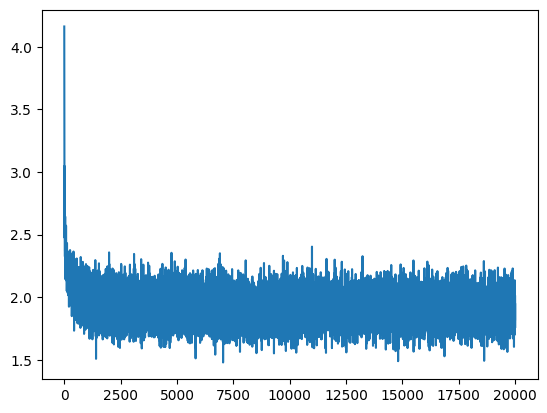

In [30]:
# Plotting the loss
plt.plot(stepi, [i.item() for i in lossi]);

In [18]:
generate('This is a splendid day ', rnn, max_output_size=500)

This is a splendid day t ountugesour cercened:
Ob dishes thtiry ty s hes b ce s
he s tine tids is the; i, blfrs, atathI b, che hts s y 's minenete, the, p aiBut iuce -f rus
Wy s.
O ts tifes o sislde cb tusugheisis.
D cho, ces pese cervere, t tomatidas bse bfaht y t ouorid y atzhe: s t Me.
 ce ctin
is tas mis w t
e mishehased chis ne blges; bals min;
Hkserdis:
's htis s fed, he s ck Hesl ng nast ous much:
Ot hesothes
hty thtchti, chhtarhtis ot Ches lll bcero t

Os h ot y, ig:

O g s chestose t oue t:
y ty: ose be cheni

In [22]:
## Works with no issues ##
@dataclass
class ModelConfig:
    block_size: int = 8 # length of the input sequences of integers
    vocab_size: int = vocab_size # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    # n_layer: int = 1
    n_embd: int = 10
    n_embd2: int = 100
    # n_head: int = 4
    
class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        ht = F.tanh(self.xh_to_h(xh))
        return ht
        
class RNN(nn.Module):

    def __init__(self, config, cell_type):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        if cell_type == 'rnn':
            self.cell = RNNCell(config)
        elif cell_type == 'gru':
            self.cell = GRUCell(config)
        self.lm_head = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        # hprev = self.start.expand((b, -1)) # expand out the batch dimension
        ht = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            ht = self.cell(xt, ht) # (b, n_embd2)
            # hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return loss, logits
num_iters = 200_000
m = ModelConfig()

rnn = RNN(m, 'rnn')
# init optimizer
optim = torch.optim.AdamW(rnn.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-8)

for i in range(num_iters):
    x, y = get_batch(train_data)
    loss, _ = rnn(x, y)
    loss.backward()

    optim.step()
    optim.zero_grad()
    if not (i % 10000):
        print(f'step: {i}', end=' | ')
        evaluate(rnn)
        # print(f'iter: {i}: train loss: {loss:.4f}')
        print('Generating a sample: ')
        generate("Verily my lord ", rnn, max_output_size=200)
        print('\n====================================')

step: 0 | average training loss: 4.1218 | average test loss: 4.1220
Generating a sample: 
Verily my lord Lfl-qffrVbD:ZMg
wDZ,B$ Ipy!J;wg?uFTjD,IJPfTdkUKhcyMT-ig faex:;r?qCLYOHXAdWj&XYNnMDRjrP
jbPzoSBMsBcfTWKsrgBnY!eXV$aa&z:I,fr,SBNxWYYQseaS!nMcEhgf!sN NlPSHynmooZXiUrDw!krb.Q;diU!bhcmbfFulZZEhxYcy?KsEPyjW
step: 10000 | average training loss: 2.4942 | average test loss: 2.4967
Generating a sample: 
Verily my lord mbs watant turar t my n he hted nd an n gw thakero ithit.
Tin'd;
An'aallath, kk t n merurat h brertlan t g
A menem arera.
A o,
I
Cat ttn
A hiat ht p m:
Y m by I hicen n tak
Ag m m me n m An turenedy t
step: 20000 | average training loss: 2.5015 | average test loss: 2.5058
Generating a sample: 
Verily my lord dl gllll mech d dellllanallighil mell teus thlll bll bler orgelally pl mimill gha hs d s l cal ilar y Lobely te mllell; had d my g ly hhiad ml dlgl.
Ll l y mhillaly d olldellfr cechmy tellllllr thalav
step: 30000 | average training loss: 2.5356 | average test loss: 2.5386
Ge